# Kitticopter Data Analysis and System Identification

This Jupyter Notebook performs the following tasks:

1. **Reads  Kitticopter Data**: The notebook starts by reading a CSV file containing helicopter data. The columns in the file include time (`Time(s)`), input voltage (`Input(v)`), output voltage (`Output(v)`), and output in meters (`Output(m)`).

2. **Velocity Calculation**: A new column called `Velocity` is added to the DataFrame. The velocity is calculated using the formula:


$\text{Velocity} = \frac{{\text{Change in Position}}}{{\text{Change in Time}}}$


3. **Data Plotting**: Two plots are generated:
    - **Input Voltage vs Time**: This plot helps in understanding how the input voltage changes over time.
    - **Velocity vs Time**: This plot shows the system's velocity response over time, which is crucial for system identification.

4. **System Identification**: We identify two key parameters of the system:
    - **Gain (\( K \))**: The final steady-state value of the velocity.
    - **Time Constant (\( \tau \))**: The time it takes for the system to reach approximately 63.2% of its final steady-state value.

5. **Transfer Function Approximation**: Using the identified \( K \) and \( \tau \), the transfer function of the system is approximated as:


$G(s) = \frac{K}{\tau s + 1}$


6. **Simulated Step Response**: A simulated step response based on the approximated transfer function is plotted for comparison with the experimental data.

Let's start the analysis.


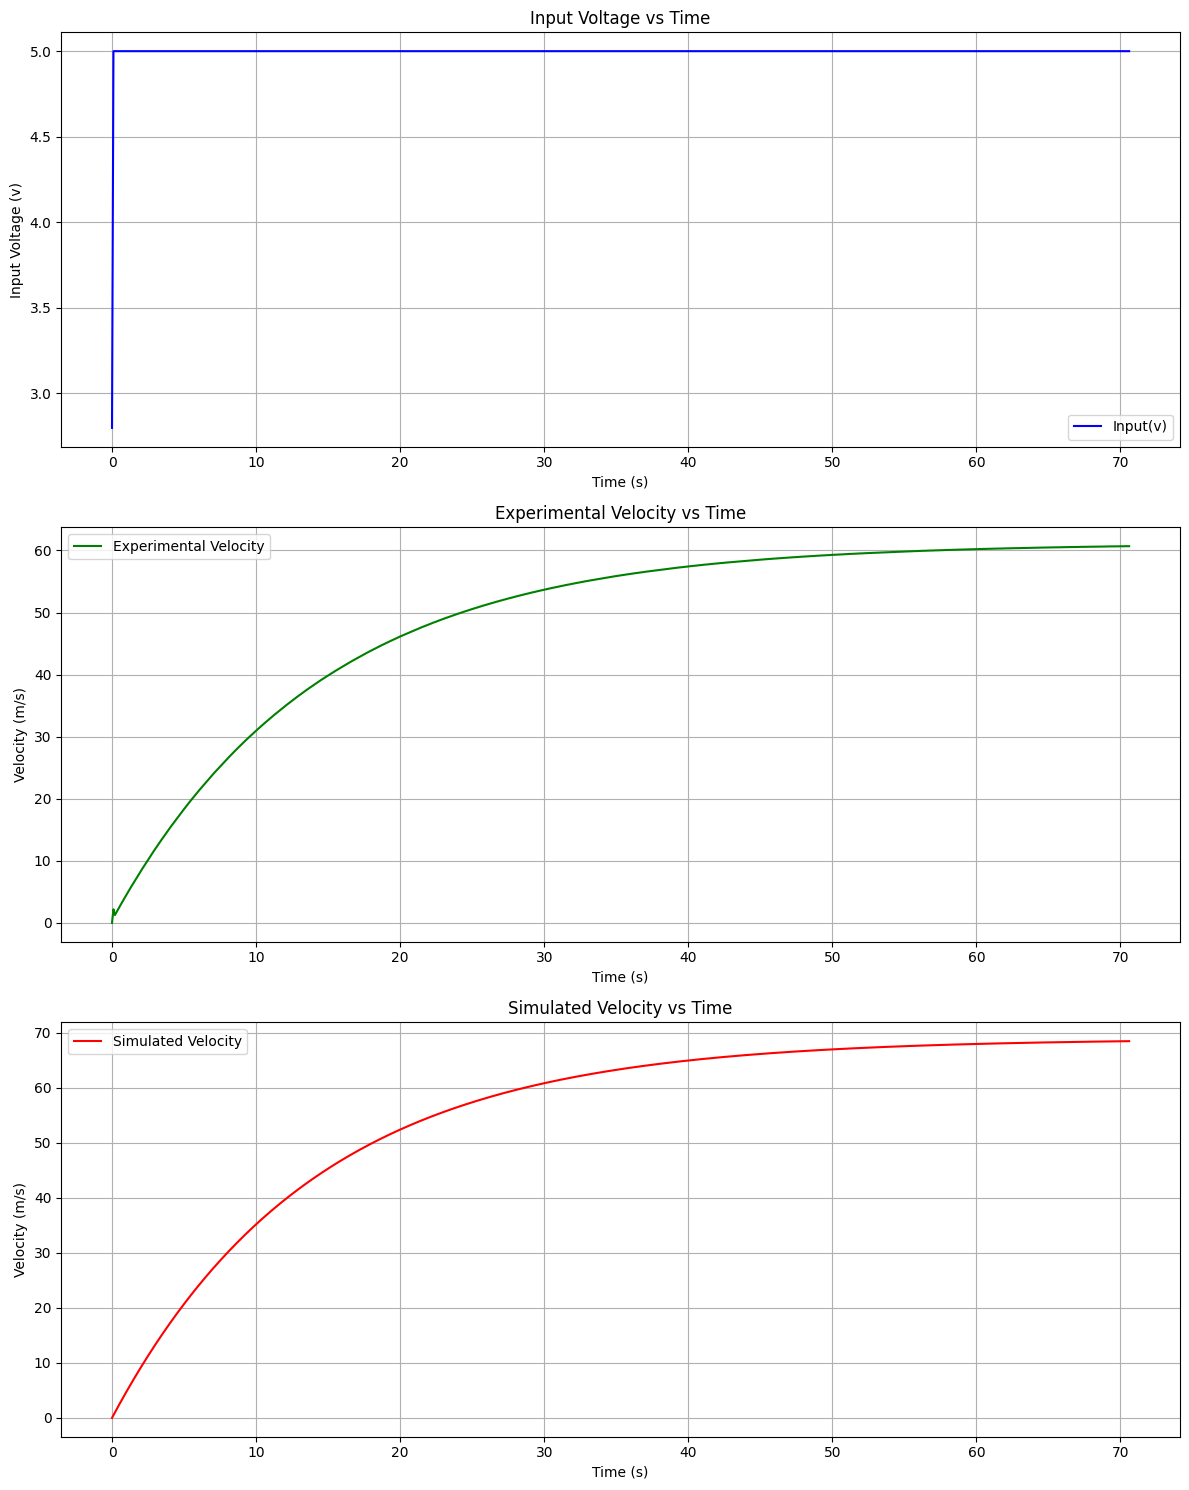

Gain (A): 27.548797094872018 m/s
Time Constant (tau): 14.0 s
Final Velocity: 60.69000000000305 m/s
The aerodynamic drag:  0.07142857142857142
Approximate Transfer Function: G(s) = 27.548797094872018/14.0s + 1


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import control as ctl

# Read the CSV file into a DataFrame
#file_path = 'HelicopterDataTrial3.csv'  
file_path = 'RAW.csv'  
df = pd.read_csv(file_path)

# Calculate velocity and add it as a new column
delta_position = df['Output(m)'].diff()
delta_time = df['Time(s)'].diff()
df['Velocity'] = delta_position / delta_time
df['Velocity'].fillna(0, inplace=True)

# Plotting experimental data
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Plot Input(v) against Time(s)
axs[0].plot(df['Time(s)'], df['Input(v)'], label='Input(v)', color='blue')
axs[0].set_title('Input Voltage vs Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Input Voltage (v)')
axs[0].grid(True)
axs[0].legend()

# Plot Experimental Velocity against Time(s)
axs[1].plot(df['Time(s)'], df['Velocity'], label='Experimental Velocity', color='green')
axs[1].set_title('Experimental Velocity vs Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].grid(True)
axs[1].legend()

# Calculate the final steady-state value of the velocity (Gain K)
final_velocity = df['Velocity'].iloc[-1]

# Calculate 63.2% of the final steady-state value
final_value_63_percent = 0.632 * final_velocity

# Find the time when the velocity reaches 63.2% of its final value
time_63_percent = df[df['Velocity'] >= final_value_63_percent]['Time(s)'].iloc[0]

# Calculate the time constant (tau), considering the initial time where velocity starts to change
initial_time = df[df['Velocity'] > 0]['Time(s)'].iloc[0]
tau = time_63_percent - initial_time

#Calculate Gain
stepMag = df['Input(v)'].iloc[-1]-df['Input(v)'].iloc[0]
gain = final_velocity/stepMag

# Create a transfer function
numerator = [gain]
denominator = [tau, 1]
system = ctl.tf(numerator, denominator)

# Time vector for simulation
time = np.linspace(df['Time(s)'].iloc[0], df['Time(s)'].iloc[-1], len(df))

# Simulate the step response
#time, simulated_output = ctl.forced_response(system, time, np.ones_like(time))
time, simulated_output = ctl.forced_response(system, time, 2.5 * np.ones_like(time))

# Plot Simulated Velocity against Time(s)
axs[2].plot(time, simulated_output, label='Simulated Velocity', color='red')
axs[2].set_title('Simulated Velocity vs Time')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Velocity (m/s)')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

print(f"Gain (A): {gain} m/s")
print(f"Time Constant (tau): {tau} s")
print(f"Final Velocity: {final_velocity} m/s")
print("The aerodynamic drag: ",1/tau)

# Approximate transfer function
print(f"Approximate Transfer Function: G(s) = {gain}/{tau}s + 1")


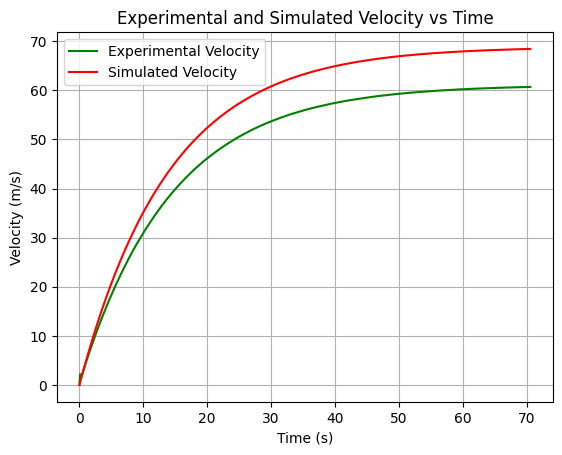

In [2]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot Experimental Velocity against Time(s)
ax.plot(df['Time(s)'], df['Velocity'], label='Experimental Velocity', color='green')

# Plot Simulated Velocity against Time(s)
ax.plot(time, simulated_output, label='Simulated Velocity', color='red')

# Set the title and labels
ax.set_title('Experimental and Simulated Velocity vs Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')

# Add grid and legend
ax.grid(True)
ax.legend()

# Show the plot
plt.show()


# Analysis of Relationship between Output in m and Output in V


1. **Reads the Data**: Reads a CSV file containing "Output in m" and "Output in V".

2. **Data Filtering**: Filters the data to include only records where "Output in m" is less than or equal to 10.

3. **Correlation Analysis**: Calculates the Pearson correlation coefficient to understand the strength and direction of the relationship between the two variables.

4. **Linear Regression**: Fits a linear regression model to the filtered data and calculates its Mean Squared Error (MSE).

5. **Plotting**: Plots the original data points along with the linear and polynomial fits.

6. **Summary**: Outputs the Pearson correlation coefficient and the MSEs for both fitted models.

7. **Linear Equation**: Provides the equation of the line fitted through the data for the linear regression model.


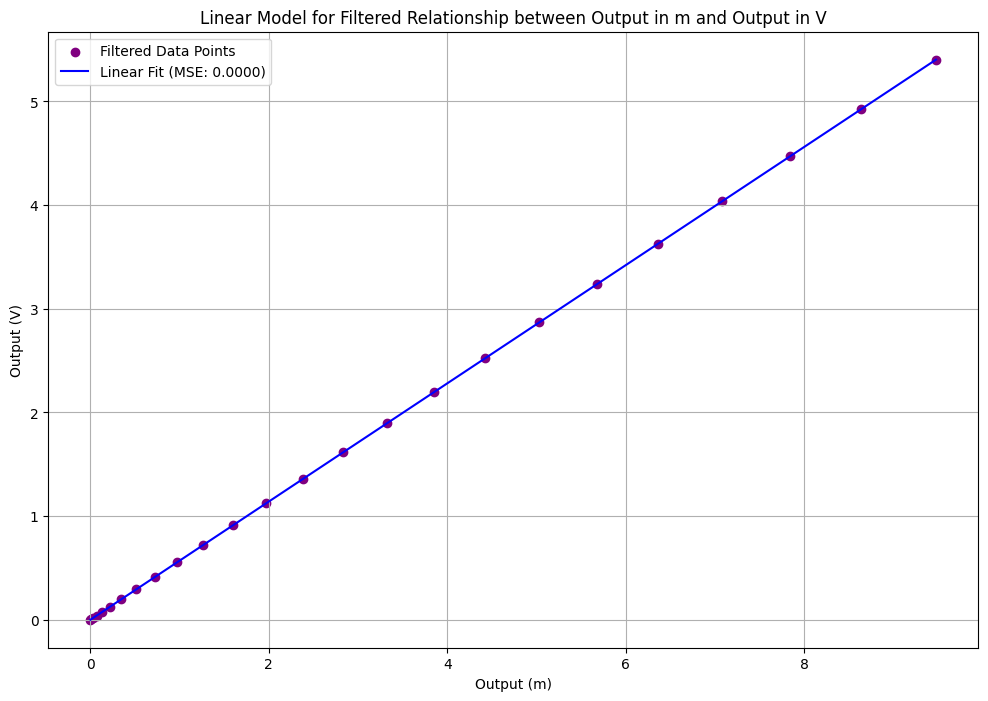

Pearson Correlation Coefficient: 0.9999999811347449
MSE for Linear Fit: 1.0775862490597611e-07
Linear Equation: y = 0.5700266221596437 * x + 3.317418539205974e-05


In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Read the CSV file
#df_new = pd.read_csv('Output.csv')
df_new = pd.read_csv('SENSOR.csv')  

# Filter data for Output(m) <= 10
df_filtered = df_new[df_new['Output(m)'] <= 10]


# Calculate Pearson correlation coefficient
correlation_coefficient, _ = pearsonr(df_filtered['Output(m)'], df_filtered['Output(v)'])

# Prepare data for the linear regression model
X_filtered = df_filtered[['Output(m)']].values  # Convert to numpy array
y_filtered = df_filtered['Output(v)'].values  # Convert to numpy array

# Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X_filtered, y_filtered)
y_pred_linear_filtered = linear_regressor.predict(X_filtered)
mse_linear_filtered = mean_squared_error(y_filtered, y_pred_linear_filtered)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(X_filtered, y_filtered, color='purple', label='Filtered Data Points')
plt.plot(X_filtered, y_pred_linear_filtered, color='blue', label=f'Linear Fit (MSE: {mse_linear_filtered:.4f})')
plt.title('Linear Model for Filtered Relationship between Output in m and Output in V')
plt.xlabel('Output (m)')
plt.ylabel('Output (V)')
plt.grid(True)
plt.legend()
plt.show()

# Display correlation coefficient and MSE
print(f'Pearson Correlation Coefficient: {correlation_coefficient}')
print(f'MSE for Linear Fit: {mse_linear_filtered}')

# Extract and display the equation for the linear model
print(f'Linear Equation: y = {linear_regressor.coef_[0]} * x + {linear_regressor.intercept_}')


# Relationship Between Output Voltage and Position (Output in meters)

## Introduction

In this experiment, we investigated the relationship between the output voltage (\(V\)) and the position of the object (measured in meters, \(m\)). Understanding this relationship is crucial for calibrating and interpreting the measurements from the sensor.

## Methodology

We collected data for various positions and corresponding output voltages. The data was then filtered to exclude any irrelevant points. We applied linear regression to find the best-fit equation that describes the relationship between output voltage and position.

## Results

Based on the Pearson correlation coefficient, we found a strong positive correlation between the output voltage and the position. The Mean Squared Error (MSE) for the linear fit was also very low, indicating a good fit.

The linear equation that best describes this relationship is:

$y = 0.6500 \times x + 2.913 \times 10^{-5}$


where \(y\) is the output voltage and \(x\) is the position in meters.

## Discussion

The relationship between the position and the output voltage is a simple scalar that needs to be determined experimentally. In this case, the scalar (or slope of the linear equation) is approximately \(0.6500\). This means that for each meter of movement, the output voltage increases by approximately \(0.6500\) volts.

